# lab 5: translation simple ecoder-decocer

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data
import pandas as pd
import unicodedata
import string
import re
import random
from contra_qa.plots.functions  import simple_step_plot
import  matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from nltk.translate.bleu_score import sentence_bleu


% matplotlib inline

### Preparing data

In [2]:
df2 = pd.read_csv("data/boolean2_train.csv")

df2train = df2.iloc[:8500]
df2valid = df2.iloc[8500:]

In [3]:
df2train.tail()

,sentence1,sentence2,and_A,and_B,label
8495,Agnes is proud and Lauren is ambitious,Agnes is not proud,Agnes is proud,Lauren is ambitious,1
8496,Curtis is wonderful and Jessie is ambitious,Curtis is not wonderful,Curtis is wonderful,Jessie is ambitious,1
8497,Brett is dead and Tracy is important,Tracy is not important,Brett is dead,Tracy is important,1
8498,Lauren is hallowed and Yvette is shy,Yvette is not shy,Lauren is hallowed,Yvette is shy,1
8499,Kathleen is alive and Dustin is clever,Dustin is not clever,Kathleen is alive,Dustin is clever,1


In [4]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


example = "ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf"
print("Before:", example)
print()
print("After:", normalizeString(example))

Before: ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf

After: ddddda capoeeeeeee ! ! aas fdf


In [6]:
pairs_A = list(zip(list(df2train.sentence1.values), list(df2train.and_A.values)))
pairs_B = list(zip(list(df2train.sentence1.values), list(df2train.and_B.values)))
pairs_A = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A]
pairs_B = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B]

In [7]:
def readLangs(lang1, lang2, pairs, reverse=False):
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [tuple(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [8]:
eng_enc, eng_dec, pairs_A = readLangs("eng_enc",
                                      "eng_dec",
                                      pairs_A,
                                      reverse=False)

In [9]:
MAX_LENGTH = 20


def filterPair(p):
    cond1 = len(p[0].split(' ')) < MAX_LENGTH
    cond2 = len(p[1].split(' ')) < MAX_LENGTH 
    return cond1 and cond2


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


In [10]:
def prepareData(lang1, lang2, pairs, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, pairs, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData("eng_enc",
                                             "eng_dec",
                                             pairs_A)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 705
eng_dec 704


### sentences 2 tensors

In [11]:
example = random.choice(pairs)
print(example)

('alfred is helpful and annette is important', 'alfred is helpful')


In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

In [13]:
indexesFromSentence(input_lang,example[0])

[114, 3, 83, 5, 508, 3, 100]

In [14]:
indexesFromSentence(output_lang, example[1])

[67, 3, 89]

In [15]:
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [16]:
input_sen = tensorFromSentence(input_lang,example[0])
output_sen = tensorFromSentence(output_lang, example[1])

print(input_sen)
print()
print(input_sen.shape)
print(input_sen.dtype)
print(output_sen)
print()
print(output_sen.shape)
print(output_sen.dtype)

tensor([[114],
        [  3],
        [ 83],
        [  5],
        [508],
        [  3],
        [100],
        [  1]])

torch.Size([8, 1])
torch.int64
tensor([[67],
        [ 3],
        [89],
        [ 1]])

torch.Size([4, 1])
torch.int64


In [17]:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [18]:
input_sen, output_sen = tensorsFromPair(example)


print("input\n")
print(input_sen)
print()
print(input_sen.shape)
print(input_sen.dtype)

print("\noutput\n")
print(output_sen)
print()
print(output_sen.shape)
print(output_sen.dtype)

input

tensor([[114],
        [  3],
        [ 83],
        [  5],
        [508],
        [  3],
        [100],
        [  1]])

torch.Size([8, 1])
torch.int64

output

tensor([[67],
        [ 3],
        [89],
        [ 1]])

torch.Size([4, 1])
torch.int64


In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [20]:
hidden_size = 10
eng_enc_v_size = 705
eng_dec_v_size = 704

In [21]:
encoder = EncoderRNN(eng_enc_v_size, hidden_size)
h0 = encoder.initHidden()
print("input_sen:", input_sen.shape, input_sen.dtype)
print("h0:", h0.shape, h0.dtype)

input_sen: torch.Size([8, 1]) torch.int64
h0: torch.Size([1, 1, 10]) torch.float32


In [22]:
max_length = 20
encoder_outputs = torch.zeros(max_length,
                              encoder.hidden_size,
                              device=device)

input_length = input_sen.size(0)

for ei in range(input_length):
    output, hidden_enc = encoder(input_sen[ei], h0)
    h0 = hidden_enc
    encoder_outputs[ei] = output[0, 0]

print("output:", output.shape, output.dtype)
print("hidden_enc:", hidden_enc.shape, hidden_enc.dtype)

output: torch.Size([1, 1, 10]) torch.float32
hidden_enc: torch.Size([1, 1, 10]) torch.float32


In [23]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [24]:
decoder = DecoderRNN(hidden_size, eng_dec_v_size)

decoder_input = torch.tensor([[SOS_token]], device=device)

decoder_hidden = hidden_enc

target_length = output_sen.size(0)

for di in range(target_length):
    decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
    decoder_input = output_sen[di]  # Teacher forcing
    print("decoder_output:", decoder_output.shape, decoder_output.dtype)
    print()
    print("decoder_hidden:", decoder_hidden.shape, decoder_hidden.dtype)    


decoder_output: torch.Size([1, 704]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 704]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 704]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32
decoder_output: torch.Size([1, 704]) torch.float32

decoder_hidden: torch.Size([1, 1, 10]) torch.float32


## Calculate loss over each token of the target language

In [28]:
learning_rate = 0.2
encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [29]:
MAX_LENGTH = 10

def train(input_tensor,
          target_tensor,
          encoder,
          decoder,
          encoder_optimizer,
          decoder_optimizer,
          criterion,
          max_length=MAX_LENGTH,
          teacher_forcing_ratio=0.5):

    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length,
                                  encoder.hidden_size,
                                  device=device)
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    use_teacher_forcing = True

    if not random.random() < teacher_forcing_ratio:
        use_teacher_forcing = False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            _, topone = decoder_output.topk(1)
            decoder_input = topone.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

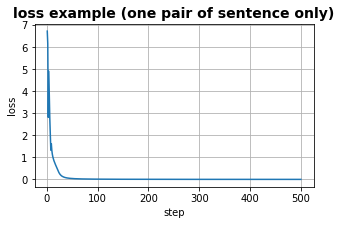

In [30]:
losses = []
for i in range(500):
    loss = train(input_sen,
          output_sen,
          encoder,
          decoder,
          encoder_optimizer,
          decoder_optimizer,
          criterion,
          max_length=MAX_LENGTH)
    losses.append(loss)

simple_step_plot([losses],
                 "loss",
                 "loss example (one pair of sentence only)",
                 "loss_example.png",
                  figsize=(5,3))

In [31]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since):
    now = time.time()
    s = now - since
    return '%s' % asMinutes(s)

In [38]:
n_iters = 1000
# training_pairs = [tensorsFromPair(random.choice(pairs))
#                   for i in range(n_iters)]

training_pairs = pairs

# losses = []
# start = time.time()

for t in training_pairs:
    input_sen, output_sen = t    
    loss = train(input_sen,
          output_ sen,
#           encoder,
#           decoder,
#           encoder_optimizer,
#           decoder_optimizer,
#           criterion,
#           max_length=MAX_LENGTH)
#     losses.append(loss)

# print(timeSince(start))

# simple_step_plot([losses],
#                  "loss",
#                  "loss example ({} pair of sentences only)".format(n_iters),
#                  "loss_example.png",
#                   figsize=(10,3))

In [33]:
def trainIters(encoder,
               decoder,
               n_iters,
               status_every=100,
               learning_rate=0.01,
               teacher_forcing_ratio=0.5):

    plot_losses = []
    old = 0
    start = time.time()
    all_loss = []

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]

    for i, t in enumerate(training_pairs):
        input_sen, output_sen = t
        loss = train(input_sen,
                     output_sen,
                     encoder,
                     decoder,
                     encoder_optimizer,
                     decoder_optimizer,
                     criterion,
                     max_length=MAX_LENGTH,
                     teacher_forcing_ratio=teacher_forcing_ratio)
        plot_losses.append(loss)

        if i % status_every == 0 and i != 0:
            print("mean loss = {:.2f}\n".format(np.mean(plot_losses)))
            print("time in {} steps:".format(status_every), timeSince(start))
            simple_step_plot([plot_losses],
                             "loss",
                             "loss plot (from {} to {})".format(old, i),
                             "loss_example.png",
                             figsize=(10, 3))
            all_loss += plot_losses
            plot_losses = []
            old = i
            start = time.time()
    
    simple_step_plot([all_loss],
                     "loss",
                     "loss over training" ,
                     "loss_example.png",
                     figsize=(15, 3))


## translating

In [34]:
def translate(encoder,
              decoder,
              sentence,
              max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()

        return " ".join(decoded_words)

## translation of a non trained model